In [11]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from shapely import box
from shapely.ops import clip_by_rect
from skfem import Basis, ElementDG, ElementTriP1
from skfem.io.meshio import from_meshio
from tqdm import tqdm

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict

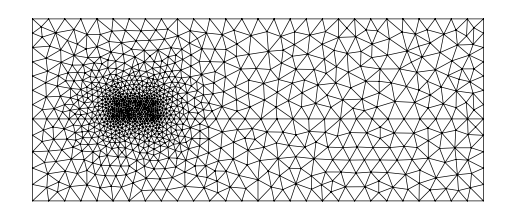

In [12]:

wg_width = 0.5
wg_thickness = 0.22
pml_distance = wg_width / 2 + 2
pml_thickness = 2
core = box(-wg_width / 2, 0, + wg_width / 2, wg_thickness)
env = box(-1 - wg_width / 2, -1, pml_distance + pml_thickness, wg_thickness + 1)

polygons = OrderedDict(
    core = core, 
    box = clip_by_rect(env, -np.inf, -np.inf, np.inf, 0), 
    clad = clip_by_rect(env, -np.inf, 0 ,np.inf, np.inf),
)

resolutions = dict(core = {"resolution": 0.03, "distance": 1})

mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.2, filename = "msh.msh"))
mesh.draw().show()

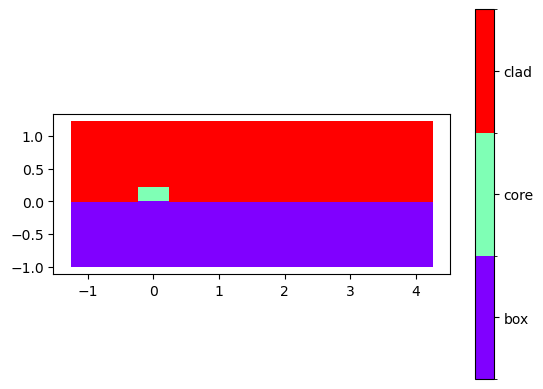

In [13]:
from femwell.visualization import plot_domains
plot_domains(mesh)
plt.show()

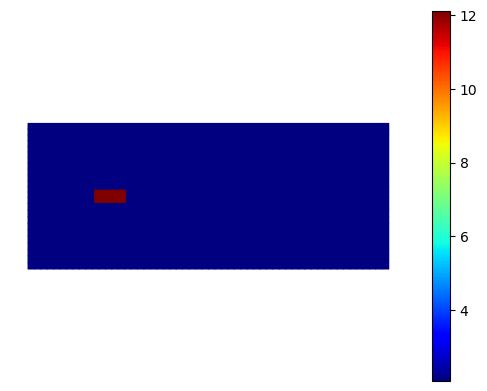

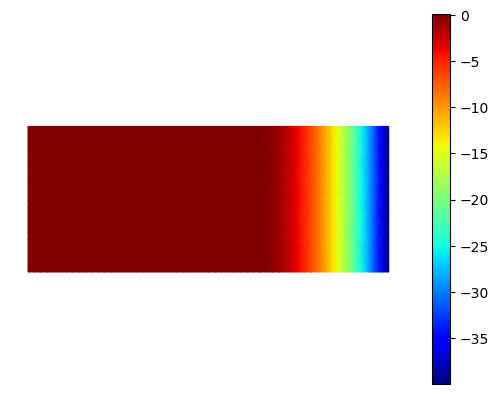

In [15]:
basis0 = Basis(mesh, ElementDG(ElementTriP1()))
epsilon = basis0.zeros(dtype=complex)
for subdomain, n in {"core": 3.48, "box": 1.44, "clad": 1.44}.items():
    epsilon[basis0.get_dofs(elements=subdomain)] = n**2
epsilon += basis0.project(
    lambda x: -10j * np.maximum(0, x[0] - pml_distance) ** 2,
    dtype = complex,
)

basis0.plot(epsilon.real, shading = 'gouraud', colorbar = True).show()
basis0.plot(epsilon.imag, shading = 'gouraud', colorbar = True).show()

In [16]:
wavelength = 1.55
modes_straight = compute_modes(
    basis0, epsilon, wavelength=wavelength, num_modes=1, order = 2, radius = np.inf
)

In [28]:
radiuss = np.arange(4, 7)
radiuss_lams = []
overlaps = []
lam_guess = modes_straight[0].n_eff
for radius in tqdm(radiuss):
    modes = compute_modes(
        basis0,
        epsilon,
        wavelength=wavelength,
        num_modes=3,
        order=2,
        radius=radius,
        n_guess= lam_guess,
        solver="scipy",
    )
    lam_guess = modes[0].n_eff
    radiuss_lams.append(modes[0].n_eff)

    overlaps.append(modes_straight[0].calculate_overlap(modes[0]))


100%|██████████| 3/3 [00:11<00:00,  3.79s/it]


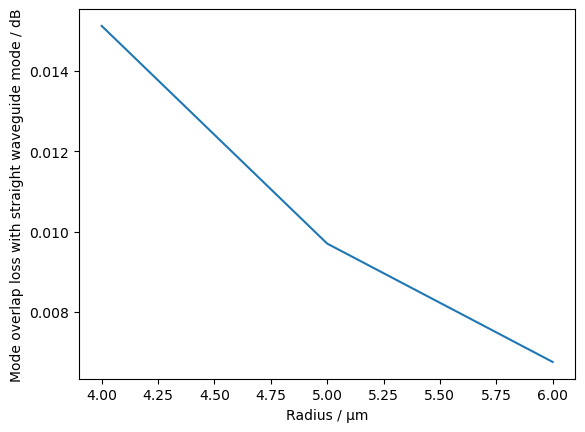

In [29]:
plt.xlabel("Radius / μm")
plt.ylabel("Mode overlap loss with straight waveguide mode / dB")
# plt.yscale("log")
plt.plot(radiuss, -10 * np.log10(np.abs(overlaps)))
plt.show()

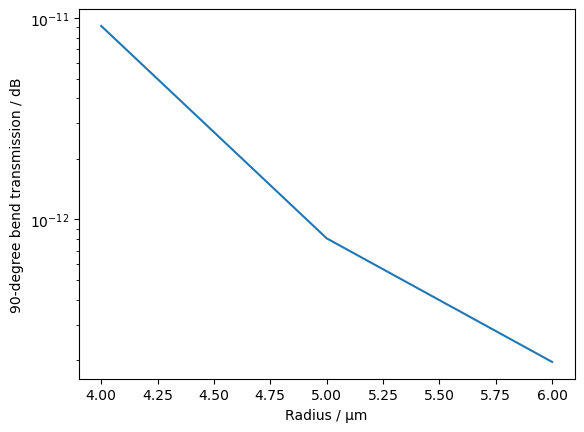

In [25]:
plt.xlabel("Radius / μm")
plt.ylabel("90-degree bend transmission / dB")
plt.yscale("log")
plt.plot(
    radiuss,
    -10
    * np.log10(
        np.exp(-2 * np.pi / wavelength * radius * np.abs(np.imag(radiuss_lams)) * np.pi / 2)
    ),
)
plt.show()

Effective refractive index: 2.45238639104189-0.00000000000000j


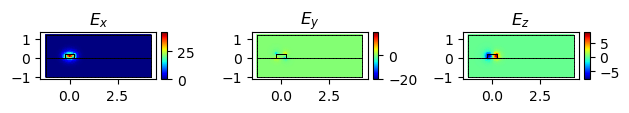

Effective refractive index: 1.81398167834931-0.04934738881659j


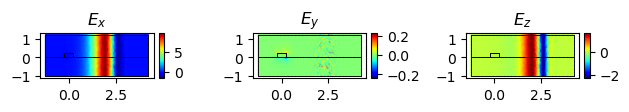

Effective refractive index: 1.79743810149434-0.03700219579219j


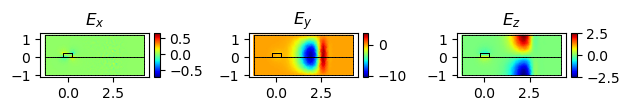

In [30]:
for mode in modes:
    print(f"Effective refractive index: {mode.n_eff:.14f}")
    mode.plot(mode.E.real, colorbar=True, direction="x")
    plt.show()